# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile 

**Fecha de entrega: 2 de octubre de 2020**

[Hoja de Respuestas (con tests automáticos)](https://drive.google.com/file/d/1Xj_0rvpf3zXV69A9xWlohrL8068IrbqZ/view?usp=sharing)

En las primeras tareas del curso **progamarás a mano** varios aspectos de redes neuronales Feed Forward. La idea es familiarizarse con tensores, funciones de activación, derivadas, el algoritmo de backpropagation, algoritmos de optimización, regularización, entrenamiento, y búsqueda de hiperparámetros. No se espera obtener excelentes resultados en problemas de clasificación reales, si no más bien aplicar los conceptos teóricos aprendidos en clases y así entenderlos de manera más precisa.  En esta primera tarea sólo nos preocupará la función `forward` de una red neuronal y usaremos una red pre-entrenada para el conjunto de datos MNIST. 

Te recomendamos que comiences por familiarizarte un poco con [tensores de pytorch](https://pytorch.org/docs/stable/tensors.html) y sus operaciones, que son el objeto básico que usaremos en esta y las siguientes tareas. El material necesario para resolver esta tarea es el siguiente:
* [Video: Perceptrón, funciones de activación, y representación matricial](https://www.youtube.com/watch?v=mDCxK2Pu0mA) 
* [Video: MLP, redes feed-forward, y función de salida](https://www.youtube.com/watch?v=eV-N1ozcZrk&t=1710) (desde el minuto 28:30)
* [Apuntes de Redes Feed Forward](https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile/raw/master/2019/clases/apuntes/1_FFNN.pdf)

IMPORTANTE: A menos que se exprese lo contrario, sólo podrás utilizar las clases y funciones en el módulo [`torch`](https://pytorch.org/docs/stable/torch.html). Hay excepciones explicadas en el enunciado de la tarea más adelante. 

(por Jorge Pérez, https://github.com/jorgeperezrojas, [@perez](https://twitter.com/perez))


In [1]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente:
# !pip install -q ipdb
# import ipdb

# Parte 1: Funciones de activación y función de salida

En esta parte programarás varias funciones que serán de utilidad cuando construyas tu red neuronal. Una cosa **muy importante en esta y las siguientes partes**: evita los loops (`for`, `while`, etc.) a toda costa! todo lo que se pueda hacer con operaciones de tensores sin iterar será muy eficiente (en CPU y GPU).

## 1a) Funciones de activación

En esta parte debes programar las siguientes funciones de activación:

*   `relu`, que para cada valor $x$ en un tensor computa el máximo entre $0$ y $x$,  
*   `swish`, propuesta en el artículo [Searching for Activation Functions](https://arxiv.org/abs/1710.05941), y
*   `celu`, propuesta en el artículo [Continuously Differentiable Exponential Linear Units](https://arxiv.org/abs/1704.07483).

En cada caso tu función debe recibir un tensor (de cualquier cantidad de dimensiones) y entregar un tensor con la función aplicada a todos sus elementos. La aplicación de las funciones debe ser *punto a punto*, por lo que el tensor de salida de cada función debe tener las mismas dimensiones que el tensor de entrada. **Importante**:  tanto `swish` como `celu` tienen un parámetro que puede modificarse durante el entrenamiento de una red que utilice estas funciones de activación por lo que para estas funciones además del tensor debes recibir el parámetro correspondiente. 

Como ejemplo, estas son implementaciones de las funciones `sig` y `tanh`.

In [2]:
# Sigmoid(T)
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * torch.tensor(T)))

# Tanh(T)
def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

In [3]:
def relu(T):
  zeros = torch.zeros_like(T)
  return torch.max(T,zeros)

def swish(T, beta):
  T = torch.tensor(T)
  return T * sig(T*beta)

def celu(T, alpha):
  import math
  # output
  output = torch.zeros_like(T)
  def celu_i(x):
    '''
    Aux function
    '''
    if x >= 0:
      return x
    else:
      return alpha*(math.exp(x/alpha)-1)

  return T.apply_(celu_i)
  

In [4]:
# otras pruebas
T = torch.randn(4,4)
b = 10
print(T)
print('='*82)
print(T*b)

tensor([[ 0.5979,  0.9574,  1.2297, -0.6452],
        [ 0.3226, -0.1856,  1.7454, -0.5897],
        [ 0.9421,  1.0988, -0.6336, -1.0253],
        [ 1.7929,  1.1740,  0.6516,  1.1544]])
tensor([[  5.9793,   9.5737,  12.2969,  -6.4515],
        [  3.2263,  -1.8564,  17.4540,  -5.8970],
        [  9.4215,  10.9876,  -6.3359, -10.2535],
        [ 17.9291,  11.7395,   6.5161,  11.5444]])


In [5]:
# Prueba de relu
T = torch.randn(4, 4)
print(T)
otro_T = relu(T)
print('='*80)
print(otro_T)

tensor([[-1.1864, -0.8730, -0.7394, -0.2218],
        [ 0.4851,  0.7385,  0.2040, -0.0020],
        [ 1.0000,  0.6994, -0.6335,  1.8499],
        [ 0.3484, -1.2260, -1.0201,  0.7452]])
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.4851, 0.7385, 0.2040, 0.0000],
        [1.0000, 0.6994, 0.0000, 1.8499],
        [0.3484, 0.0000, 0.0000, 0.7452]])


In [6]:
# Prueba de swish
T = torch.randn(4, 4)
print(T)
otro_T = swish(T,10)
print('='*80)
print(otro_T)

tensor([[-1.7718,  0.2166,  0.5100, -0.6773],
        [ 1.6121,  0.6071, -1.0323,  0.3042],
        [ 0.5896,  1.2055,  0.2265,  0.8766],
        [-0.9468,  0.9440,  1.9663, -0.5711]])
tensor([[-3.5776e-08,  1.9432e-01,  5.0687e-01, -7.7426e-04],
        [ 1.6121e+00,  6.0573e-01, -3.3933e-05,  2.9032e-01],
        [ 5.8802e-01,  1.2055e+00,  2.0523e-01,  8.7644e-01],
        [-7.3158e-05,  9.4389e-01,  1.9663e+00, -1.8837e-03]])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Prueba de celu
T = torch.randn(4, 4)
print(T)
otro_T = celu(T,10)
print('='*80)
print(otro_T)

tensor([[-0.3292, -0.0192, -0.5740,  2.1043],
        [ 0.5068,  0.1979, -0.6754, -0.5120],
        [-0.0478,  1.9906, -0.6062, -0.7648],
        [ 0.0965, -0.3530, -1.2330,  1.4820]])
tensor([[-0.3239, -0.0192, -0.5578,  2.1043],
        [ 0.5068,  0.1979, -0.6531, -0.4991],
        [-0.0477,  1.9906, -0.5882, -0.7363],
        [ 0.0965, -0.3469, -1.1600,  1.4820]])


## 1b) Softmax

En esta parte debes programar la función `softmax`. Esta es una función tal que para una secuencia de valores $(x_1,\ldots,x_n)$  el resultado de $\text{softmax}(x_1,\ldots,x_n)$ es otra secuencia $(s_1,\ldots,s_n)$ que cumple con
\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation}
Para esto primero demuestra que si a cada elemento de $(x_1,\ldots,x_n)$ se le resta el mismo valor, entonces el resultado de `softmax` no varía. Es decir que $\text{softmax}(x_1-M,\ldots,x_n-M)=\text{softmax}(x_1,\ldots,x_n)$. Usa este hecho para programar una versión de `softmax` que primero le resta a todos los elementos el máximo valor de la secuencia. Esta nueva versión debiera ser numéricamente más estable.

Tu función debe recibir un tensor y el resultado de `softmax` debiera calcularse sobre alguna dimensión del tensor dejando todas las demás dimensiones fijas. Para esto tu función debe también recibir el parámetro `dim` (que indica la dimensión). El resultado de `softmax` se calculará para cada secuencia de valores obtenidos recorriendo la dimensión `dim` fijando las otras dimensiones. Por ejemplo, si `softmax` recibe un tensor de dos dimensiones $T_{ij}$ y se elige la dimensión $1$, entonces se debe computar $\text{softmax}(T_{i1},\ldots,T_{in})$ para cada $i$. Note que en este caso se calculó `softmax` sobre la dimensión $1$ (la segunda dimensión) dejando fija la dimensión $0$ (la primera dimensión). Como otro ejemplo, si el input de la función es un tensor de tres dimensiones $T_{ijk}$ y se elige la dimensión $2$ (tercera dimensión), entonces se debe computar $\text{softmax}(T_{ij1},\ldots,T_{ijn})$ para cada par $i$, $j$. Por si estás familiarizado con `numpy`, el uso de `dim` en esta parte es muy similar al de `axis` en `numpy`.

Nota que el resultado de `softmax` es siempre un tensor de las mismas dimensiones de la entrada.

(La demostración puedes entregarla en otro archivo o incluirla directamente en una celda de la [hoja de respuestas](https://drive.google.com/file/d/1NANjiWP7fWyRBWOf2Pp2gkpRkXheB54s/view?usp=sharing))

## Demostracion:
Por demostrar: $\text{softmax}(x_1-M,\ldots,x_n-M)=\text{softmax}(x_1,\ldots,x_n)$ \\
\begin{align}
s_i &= \frac{e^{x_i - M}}{\sum_{j=1}^{n}e^{x_j - M}} \\
\\
     & = \frac{e^{x_i}\cdot e^{-M}}{\sum_{j=1}^{n}e^{x_j}\cdot e^{-M}} \\
\\
     & = \frac{e^{x_i}\cdot e^{-M}}{e^{-M} \cdot \sum_{j=1}^{n}e^{x_j}}
\end{align}

Luego, simplificando el termino $e^{-M}$, queda que: \\
\begin{equation}
s_i = \frac{e^{x_i}}{\sum_{j=1}^{n}e^{x_j}}
\end{equation} \\
De esta forma, se demuestra que $\text{softmax}(x_1-M,\ldots,x_n-M)=\text{softmax}(x_1,\ldots,x_n)$.


In [8]:
# Tu código acá

def softmax(T, dim, estable=True):
  if estable:
    exp_i = torch.exp(T - torch.max(T))
    softm = torch.tensor(exp_i/torch.sum(exp_i, dim, keepdim=True))
    return softm
  else: 
    exp_i = torch.exp(T)
    softm = torch.tensor(exp_i/torch.sum(exp_i, dim, keepdim=True))
    return softm

# Parte 2: Red neuronal y pasada hacia adelante (forward)

En esta parte empezaremos a programar nuestra red neuronal, en particular la pasada hacia adelante para una red que resolverá problemas de clasificación con varias clases. Supondremos que cada capa se verá de la forma
\begin{equation}
h^{(\ell)} = f^{(\ell)}(h^{(\ell-1)} W^{(\ell)}+b^{(\ell)})
\end{equation}
y que la predicción final estará dada por
\begin{equation}
\hat{y} = \text{softmax}(h^{(L)}U+c).
\end{equation}

(Para entender los detalles de estas fórmulas puedes ver los [apuntes de redes feed forward](https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile/raw/master/2019/clases/apuntes/1_FFNN.pdf).)

## 2a) Clase para red neuronal

Programa una clase `FFNN` que en su inicializador reciba los siguientes parámetros:

*   Cantidad de neuronas de la capa de entrada `F`
*   Lista de cantidades de neuronas en cada capa escondida `l_h`
*   Lista de funciones de activación `l_a`
*   Cantidad de neuronas de la capa de salida `C` (`C` $\geq 2$)

En pytorch, todas las redes neuronales que construyamos deben construirse como subclases de [`torch.nn.Module`](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), lo que tendrá varias ventajas que explicaremos después. El inicio de tu código debe verse más o menos así:

```python
class FFNN(torch.nn.Module):
  def __init__(self, ...):
    super(FFNN, self).__init__()
```

El inicializador de tu clase debería crear todos los parámetros para la red como tensores (`torch.tensor`) de las dimensiones correspondientes, y almacenar lo necesario para poder computar la pasada hacia adelante (siguiente parte). Para poder aprovechar las funcionalidades de pytorch, debes **registrar** los parámetros como tales y para esto debes usar la clase [`torch.nn.Parameter`](https://pytorch.org/docs/stable/nn.html#torch.nn.Parameter). Por ahora, para nosotros un parámetro de la red definido con `torch.nn.Parameter` no es nada mas que un tensor y en esta tarea lo usaremos como eso, es decir, utilizando solo las funciones básicas de [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html). El siguiente trozo de código crea un tensor de 100 x 100 con solo zeros y lo registra como parámetro en la red.

```python
class FFNN(torch.nn.Module):
  def __init__(self, ...):
    super(FFNN, self).__init__()
    T = torch.zeros(100,100)
    self.mi_parametro = torch.nn.Parameter(T)
```

Inicializa todos los parámetros con números aleatorios pequeños y los sesgos como 0. No olvides definir los parámetros como artibutos de la clase para que otros métodos de la clase tengan acceso a ellos también. En tu caso, como tendrás una cantidad variables de parámetros, debes usar una [torch.nn.ParameterList](https://pytorch.org/docs/stable/nn.html#torch.nn.ParameterList) para agregar los parámetros, que estos queden todos registrados y que las otras funciones tengan acceso a ellos.

Una llamada de ejemplo para crear un objeto de tu clase es:
```python
red_neuronal = FFNN(300,[50,30],[relu,sig],10)
``` 
lo que debiera crear todos los parámetros para una red con 300 neuronas en la capa de entrada, luego una capa escondida de 50 neuronas con activación relu, luego una capa con 30 neuronas y activación sigmoid y finalmente una capa de 10 neuronas de salida. <br><br>

Puedes agregarle al inicializador de tu clase todos los parámetros opcionales que estimes conveniente, y construir las funciones que te parezcan importantes de construir. Por ejemplo, es recomendable tener alguna forma de asignar los valores iniciales de los parámetros de la red, lo que servirá por ejemplo para cargar redes pre-entrenadas, inicializar los valores de manera más efectiva, o para hacer debugging del código. También puedes pedir los valores iniciales de los parámetros adicionales de las funciones `celu` y `swish`  (no olvides registrarlos como parámetros también!).

In [9]:
# Tu código debiera comenzar así (ojo que acá solo empieza el código, 
# lo iremos completando más adelante).

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    # capa de entrada
    self.F = torch.nn.Parameter(torch.rand(F))
    # capa oculta
    self.hidden = torch.nn.ParameterList([torch.nn.parameter(torch.rand(hidden_size)) for hidden_size in l_h])
    # funciones de activacion
    self.activation = l_a
    # capa salida
    self.C = torch.nn.Parameter(torch.rand(C))

## 2b) Iterando por los parámetros

Uno de los puntos positivos de construir una red en pytorch desde `torch.nn.Module` y registrar los parámetros usando `torch.nn.Parameter` es que puedes tener acceso a un "iterador" sobre todos los parámetros llamando a `.parameters()` (esto será muy importante más adelante cuando veamos el algoritmo de backpropagation). Usa este iterador para mostrar/imprimir un resumen de los parámetros de tu red. Debes mostrar al menos las dimensiones de cada uno de los parámetros. Puede serte útil usar el iterador `.named_parameters()` también




In [10]:
# Tu código debiera continuar así

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    # capa de entrada
    self.input_layer = torch.nn.Parameter(torch.rand(F))
    # capa oculta
    self.hidden_layer = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(hidden_size)) for hidden_size in l_h])
    # funciones de activacion
    self.activation = l_a
    # capa salida
    self.output_layer = torch.nn.Parameter(torch.rand(C))
  
  def resumen(self):
    # usa self.parameters() o self.named_parameters()
    return self.named_parameters()

In [11]:
#instanciemos una red y probemos:
red_neuronal = FFNN(300,[50,30],[relu,sig],10)
red_neuronal.resumen

<bound method FFNN.resumen of FFNN(
  (hidden_layer): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 50]
      (1): Parameter containing: [torch.FloatTensor of size 30]
  )
)>

## 2c) Moviendo los parámetros de la red entre dispositivos

Otro de los puntos positivos de construir una red en pytorch desde `torch.nn.Module` y registrar los parámetros usando `torch.nn.Parameter` es que puedes mover tu red completa entre la CPU y la GPU de manera muy simple. De hecho, como subclase de `torch.nn.Module` podemos usar el método `.to(device)`, de la siguiente forma. Si haces esto:
```python
red_neuronal = FFNN(300,[50,30],[relu,sig],10)
red_neuronal.to('cuda')
```
tu red pasa automáticamente a la GPU, lo que significa que todos los parámetros de la red quedan efectivamente almacenados en la memoria de la GPU. Para devolver los parámetros a la CPU puedes simplemente hacer
```python
red_neuronal.to('cpu')
```
También puedes usar directamente los métodos `.cuda()` y `.cpu()` para lograr los mismo efectos descritos anteriormente.

En esta parte no debes programar nada nuevo, solo comprueba que todo anda bien ejecutando las llamadas anteriores y comprobando que efectivamente la memoria de la GPU se utiliza cuando haces la llamada `to.('cuda')`.


In [12]:
# Crea una red (idealmente grande), y verifica que puedes pasar
# todos los parámetros a la GPU ejecutando !nvidia-smi para chequear
# la cantidad de GPU-RAM utilizada.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
red_neuronal.to(device)

cuda:0


FFNN(
  (hidden_layer): ParameterList(
      (0): Parameter containing: [torch.cuda.FloatTensor of size 50 (GPU 0)]
      (1): Parameter containing: [torch.cuda.FloatTensor of size 30 (GPU 0)]
  )
)

## 2d) Pasada hacia adelante

Programa la pasada hacia adelante de tu red neuronal en el método `forward` de la clase `FFNN`. La función debiera recibir un tensor de dimensiones `(B,F)` como entrada donde `B` es el tamaño del mini paquete de ejemplos pasados a tu red, y `F` la cantidad de *features* de cada ejemplo. Para computar la pasada hacia adelante, tu red debiera usar los parámetros creados en el inicializador y las funciones de activación entregadas también en el inicializador. Al finalizar, tu red debiera generar predicciones en la forma de probabilidades, aplicando la función `softmax`. El resultado del último `softmax` debiera ser un tensor de dimensiones `(B,C)` que es lo que la función debe retornar (donde `C` representa la cantidad de clases a clasificar).

In [13]:
# Tu código debiera continuar así 

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    # capa de entrada
    # capa oculta
    for i, hidden_size in enumerate(l_h):
      if i == 0:
        self.hidden_layers = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(F, hidden_size))])
      else:  
        self.hidden_layers.append(torch.nn.Parameter(torch.rand(l_h[i-1], hidden_size)))  
    # self.hidden_layers = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(hidden_size)) for hidden_size in l_h])
    # baias:
    self.baias = torch.nn.ParameterList([torch.nn.Parameter(torch.zeros(hidden_size)) for hidden_size in l_h])
    # funciones de activacion
    self.activation = l_a
    # capa salida
    self.output_layer = torch.nn.Parameter(torch.rand(l_h[i],C))
    # Baias output layer
    self.output_bias = torch.nn.Parameter(torch.zeros(C))
  
  def resumen(self):
    # usa self.parameters() o self.named_parameters()
    return self.named_parameters()

  def load_parameters(self, W, B, U, C):
    for i, layer in enumerate(self.hidden_layers):
      layer.data = (W[i])
    
    for i, baias in enumerate(self.baias):
      baias.data = (B[i])
    
    self.output_bias.data = (C)
    self.output_layer.data = (U)
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # El valor de retorno debiera ser y = softmax(capa_de_salida).
    #h = x.mm(self.input_layer)
    h = x
    for i, F in enumerate(self.activation):
      print(i)
      h = F(h @ self.hidden_layers[i] +  self.baias[i])

    out = softmax(h @ self.output_layer + self.output_bias, -1 ,  estable = True)
    return out

In [14]:
red_neuronal = FFNN(25,[50,30],[relu,sig],10)

In [15]:
print(red_neuronal)
#print(red_neuronal.input_layer.shape)
print(red_neuronal.output_layer.shape)

FFNN(
  (hidden_layers): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 25x50]
      (1): Parameter containing: [torch.FloatTensor of size 50x30]
  )
  (baias): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 50]
      (1): Parameter containing: [torch.FloatTensor of size 30]
  )
)
torch.Size([30, 10])


In [16]:
red_neuronal(torch.rand(5,25))

0
1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([[0.3010, 0.2355, 0.0038, 0.0180, 0.0059, 0.0205, 0.1848, 0.0388, 0.0164,
         0.1754],
        [0.3010, 0.2355, 0.0038, 0.0180, 0.0059, 0.0205, 0.1848, 0.0388, 0.0164,
         0.1754],
        [0.3010, 0.2355, 0.0038, 0.0180, 0.0059, 0.0205, 0.1848, 0.0388, 0.0164,
         0.1754],
        [0.3010, 0.2355, 0.0038, 0.0180, 0.0059, 0.0205, 0.1848, 0.0388, 0.0164,
         0.1754],
        [0.3010, 0.2355, 0.0038, 0.0180, 0.0059, 0.0205, 0.1848, 0.0388, 0.0164,
         0.1754]])

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

En esta parte usarás la pasada hacia adelante de tu red con parámetros de una red pre-entrenada. La red fue entrenada con el conjunto de datos MNIST que contiene datos de dígitos escritos a mano. La versión original de los datos junto con una descripción del conjunto y resultados para distintos métodos de clasificación, se pueden encontrar en http://yann.lecun.com/exdb/mnist/

## 3a) Cargando y visualizando datos de MNIST

Esta parte no requiere que escribas código, sólo que te familiarices con el conjunto de datos. Sólo sigue las instrucciones.
Primero usaremos el paquete `torchvision` (más algunos otros utilitarios) para descargar y procesar los datos de MNIST.

In [17]:
# Importamos MNIST desde torchvision.
import torchvision.datasets as datasets


# Importamos una función para convertir imágenes en tensores.
from torchvision.transforms import ToTensor

# Importamos funcionalidades útiles para mirar los datos.
from matplotlib.pyplot import subplots
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = datasets.MNIST(root='./data',
                             train=False,
                             download=True,
                             transform=ToTensor())
#dataset = MNIST('mnist', train=False, transform=ToTensor())
print('Cantidad total de datos:',len(dataset))

Cantidad total de datos: 10000


Los datos en todo dataset de pytorch se pueden acceder indexándolos como si fueran un arreglo. En el caso de MNIST cada dato es un par que contiene un tensor `T` y un entero `l`, en donde `T` representa a la imágen de un dígito, y `l` representa el valor numérico de ese dígito. Exploremos el primero de estos datos:

In [18]:
T, l = dataset[0]

print('Tensor')
print('tipo:', T.type())
print('dimensiones:', T.size())
print()
print('Entero')
print('valor:', l)

Tensor
tipo: torch.FloatTensor
dimensiones: torch.Size([1, 28, 28])

Entero
valor: 7


El tensor `T` representa una imagen de 28x28 pixeles. Nota que el dato en cuestión tiene una dimensión inicial (es un tensor de 1x28x28). Esto es porque la imagen que estamos considerando está en blanco y negro, por lo tanto tiene un solo canal de color (más adelante usaremos imágenes generales con tres canales y que por lo tanto serán representadas con tensores de dimensiones 3xHxW).

El siguiente código muestra el contenido de estos tensores de manera más amigable. Elige tres posiciones al azar y  muestra el valor `l` y el tensor `T` dibujado. Nota como se usa `view(28,28)` para redimensionar el tensor (sacarle la primera dimensión). En este caso también se usa `.numpy()` para pasar el tensor a un formato más amigable para graficar.

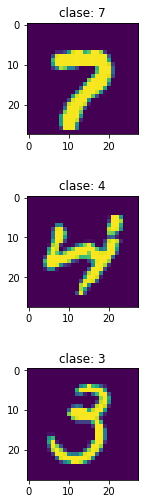

In [19]:
import random
# Muestra algunos ejemplos al azar
n_ejemplos = 3
fig, axs = subplots(nrows=n_ejemplos, figsize=(2,n_ejemplos*3))

for i in range(n_ejemplos):  
  idx = random.randint(0,len(dataset))
  T, l = dataset[idx]
  img = T.view(28,28).numpy()
  axs[i].set_title("clase: "+ str(l))
  axs[i].imshow(img)

# Note que se usó `view` para redimensionar el tensor, esto porque nuestro
# dataloader entrega un tensor de dimensiones (1,1,28,28).
# Es muy importante tener este hecho en cuenta en la siguiente parte.

## 3b) Cargando los parámetros pre-entrenados

En [este link](https://github.com/jorgeperezrojas/cc6204-DeepLearning-DCCUChile/tree/master/2019/tareas/tarea1/mnist_weights) encontrarás varios archivos de texto que representan los parámetros de una red con 2 capas escondidas que fue pre-entrenada para clasificar los datos de MNIST. La red pre-entrenada tiene esta arquitectura

784 --> 32 (relu) --> 16 (relu) --> 10 (softmax)

Nota que la cantidad de neuronas en la capa de entrada es 28*28 = 784, esto porque nuestras redes esperan un vector de características como input.

Los archivos de parámetros están nombrados como `W1`, `b1`, `W2`, `b2`, `U` y `c` que representan, respectivamente, a $W^{(1)}$, $b^{(1)}$, $W^{(2)}$, $b^{(2)}$, $U$ y $c$ en la descripción genérica que hemos utilizado para nuestras redes neuronales.

Supongamos que ya tenemos guardado el archivo `W1.txt`. Para convertir estos archivos en tensores de pytorch, puedes hacer algo como lo siguiente:

```python
from numpy import loadtxt
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
```

Usa lo anterior para crear una red con la arquitectura descrita y cargar todos los parámetros pre-entrenados en la red. Esto debes hacerlo llamando a un método de inicialización de pesos de tu red. Si no hiciste ese método en las partes anteriores, es el momento de implementarlo.

In [ ]:
# Tu código acá
# U.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/U.txt
# W1.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W1.txt
# W2.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/W2.txt
# b1.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b1.txt
# b2.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/b2.txt
# c.txt
!wget https://raw.githubusercontent.com/dccuchile/CC6204/master/versiones_anteriores/2019/tareas/tarea1/mnist_weights/c.txt


In [21]:
from numpy import loadtxt
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
U = torch.from_numpy(loadtxt('U.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
C = torch.from_numpy(loadtxt('c.txt')).float()

In [22]:
modelo = FFNN(784,[32,16],[relu,relu],10)
print(modelo)

FFNN(
  (hidden_layers): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 784x32]
      (1): Parameter containing: [torch.FloatTensor of size 32x16]
  )
  (baias): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 32]
      (1): Parameter containing: [torch.FloatTensor of size 16]
  )
)


In [23]:
for param in modelo.parameters():
  param.requires_grad = False
modelo.load_parameters([W1,W2],[b1,b2], U, C)

In [24]:
print(modelo.output_bias)
print(C)

Parameter containing:
tensor([-0.1841,  0.1299,  0.0363, -0.1974,  0.0875,  0.1237, -0.2129, -0.1553,
        -0.0097,  0.1864])
tensor([-0.1841,  0.1299,  0.0363, -0.1974,  0.0875,  0.1237, -0.2129, -0.1553,
        -0.0097,  0.1864])


## 3c) Cálcula la predicción de un ejemplo al azar

Prueba con un código tan simple como puedas, la predicción que entrega tu red para un ejemplo al azar del conjunto de datos y muestra también la imágen y la clase real del ejemplo.

0
1
tensor([9.9811e-01, 5.7510e-13, 2.5111e-06, 3.1465e-06, 2.7972e-07, 1.1341e-04,
        1.4122e-03, 7.5662e-07, 3.5664e-04, 4.2285e-06])
l =  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


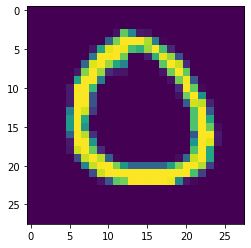

In [25]:
# Tu código aca
import random
import matplotlib.pyplot as plt
cpu = 'cpu'
modelo.to(cpu)
idx = random.randint(0,len(dataset))
T, l = dataset[idx]
img = T.view(28,28).numpy()
print(modelo.forward(T.reshape(784)))
print("l = ", l)
plt.imshow(img)

In [41]:
def accuracy(y_hat_b, yb):
    
    preds = torch.argmax(y_hat_b,dim=1)

    counts = (preds == yb)*1.0
    
    return torch.mean(counts)

In [48]:
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=100)
modelo.to(device)
acc = []
for i, (x, y) in enumerate(dataloader):
  y_hat = modelo(x.view(-1,784).to(device))
  acc.append(accuracy(y_hat.to(cpu), y.to(cpu)))

In [45]:
print("accuracy total: ", sum(acc)/len(acc))

accuracy total:  tensor(0.9612)


## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

Un `DataLoader` en pytorch es una manera muy útil de entregarle paquetes de ejemplos a una red. Será especialmente útil cuando estemos entrenando. Por ahora lo usaremos sólo para computar la predicción de la red pre-entrenada y calcular el porcentaje de acierto.

Para crear un `DataLoader` solo se debe especificar el conjunto de datos que se usará en la forma de un objeto `DataSet`, y el tamaño del paquete de cada paquete que usaremos. En el siguiente código estamos creando un `DataLoader` desde nuestro objeto `dataset` con paquetes de tamaño 100.

```python
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=100)
```

Una vez creado podemos iterar por todo el dataset haciendo simplemente:

```python
for x, y in dataloader:
  # lo que necesitemos hacer con los datos
```

En cada iteración `x` será un tensor con 100 ejemplos, por lo tanto tendrá dimensiones 100 x 1 x 28 x 28, e `y` será un tensor con las clases correspondientes a cada uno de esos ejemplos, por lo tanto tendrá dimensión 100 (es un tensor con 100 valores enteros).

Escribe una función que use un `DataLoader` para pasar todos los ejemplos por la red en paquetes y calcula el porcentaje total de acierto que la red obtiene en la predicción. Recuerda que el porcentaje total de acierto es la cantidad de ejemplos clasificados correctamente dividido por la cantidad de ejemplos. Tu función debe recibir a la red con los parámetros cargados, el dataset que usarás, el tamaño del batch para pasar por la red y si el trabajo debe hacerse en la GPU o en la CPU. Aprovecha de probar como varía el tiempo de ejecución de tu función si cambias el tamaño del paquete y si usas la GPU vs la CPU.

In [ ]:
# Acá tu código
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  pass

## 3e) Opcional: Muestra los casos en donde la red se equivoca

Muestra imágenes de 5 casos en donde la red se equivoca en la predicción (muestra la imagen y el dígito que la red predice). ¿Es razonable el error que comete?

In [ ]:
# Acá tu código

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

Usa el código en [este link](https://colab.research.google.com/drive/1pdoj2grwFUNa7ZTY5TPefsedY0VDW2_4#scrollTo=8K6u9gS-JXIT) para generar nuevos casos de prueba manualmente y ver cómo lo clasifica la red. Trata de entender en qué casos comete errores.

In [ ]:
# Acá tu código